In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Convert text files to tables

In [2]:
def txt_to_table(sim_num, redshift): # converts text file of simulation to an astropy table
    simulation = f'latin_hypercube/{sim_num}/CF_m_1024_z={redshift}.txt' # input text file
    sim_list = []
    for line in open(simulation, 'r'): # get each line
        item = line.rstrip() # strip off newline and any other trailing whitespace
        sim_list.append(item)
        
    r_list, xi_list = [], []
    for item in sim_list: # get radius and correlation from each line
        r, xi = item.split() # each line has both radius and correlation, so split
        r_list.append(float(r))
        xi_list.append(float(xi))
        
    sim_table = Table([r_list, xi_list], names=('r', 'xi')) # astropy table
    return sim_table

# Binning function

In [11]:
def binCorr(corrTable, binSize):
    rad = corrTable['r']
    xi = corrTable['xi']
    
    rSpacing = np.diff(rad)
    
    npoints = binSize + 1 # binSize is the width of each bin, and there is one more point than bins
    
    radBins = rad[0:-1:binSize]
    originalBinWidths = 0.5*np.diff(rad)[0:-1:binSize]
    if len(radBins) > len(originalBinWidths):
        radBinBounds = radBins[:-1] + 0.5*np.diff(rad)[0:-1:binSize] # new bin boundaries
    else:
        radBinBounds = radBins + 0.5*np.diff(rad)[0:-1:binSize] # new bin boundaries

    newRad = radBinBounds[:-1] + np.diff(radBinBounds)/2. # new bin centers
    binWidths = np.diff(radBinBounds)/2.

    newCorrTable = np.zeros(len(newRad))
    
    for i in range(len(newRad)):
        newCorr = 0
        for j in range(binSize):
            point = binSize*i + j + 1
            spacePoint = binSize*i + j
            pointCorr = ((rad[point] + (rSpacing[spacePoint+1]/2))**3 - (rad[point] - (rSpacing[spacePoint]/2))**3)*xi[point]
            newCorr += pointCorr
        

            newCorr /= ((newRad[i] + binWidths[i]/2)**3 - (newRad[i] - binWidths[i]/2)**3)
        
        newCorrTable[i] = newCorr
    

        
    
    binnedTable = Table([newRad, newCorrTable], names=('r', 'xi')) # astropy table

    return binnedTable
    
    
    

## Sample Plots

#### Xi vs. r truncated

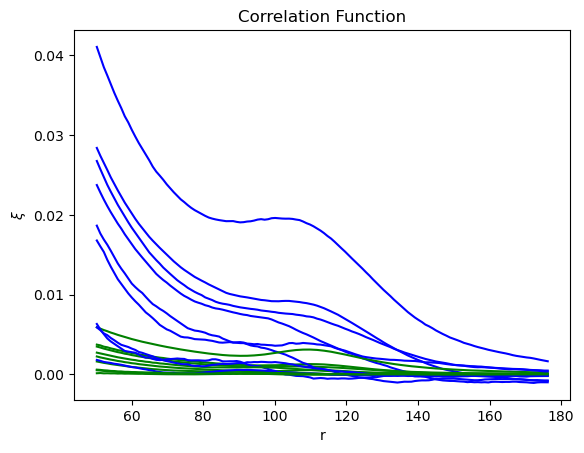

In [12]:
start=50 # start and end indices (not necessarily r)
end=180
for x in range(0,9): # simulation numbers to plot (0-2000)
    tablexz0 = txt_to_table(x, 0)[start:end] # z = 0
    tablexz3 = txt_to_table(x, 3)[start:end] # z = 3
    
    
    plt.plot(tablexz0['r'], tablexz0['xi'], c='b')
    plt.plot(tablexz3['r'], tablexz3['xi'], c='g')

    plt.xlabel('r')
    plt.ylabel('$\\xi$')
    plt.title('Correlation Function')

#### Xi r^2 vs. r truncated

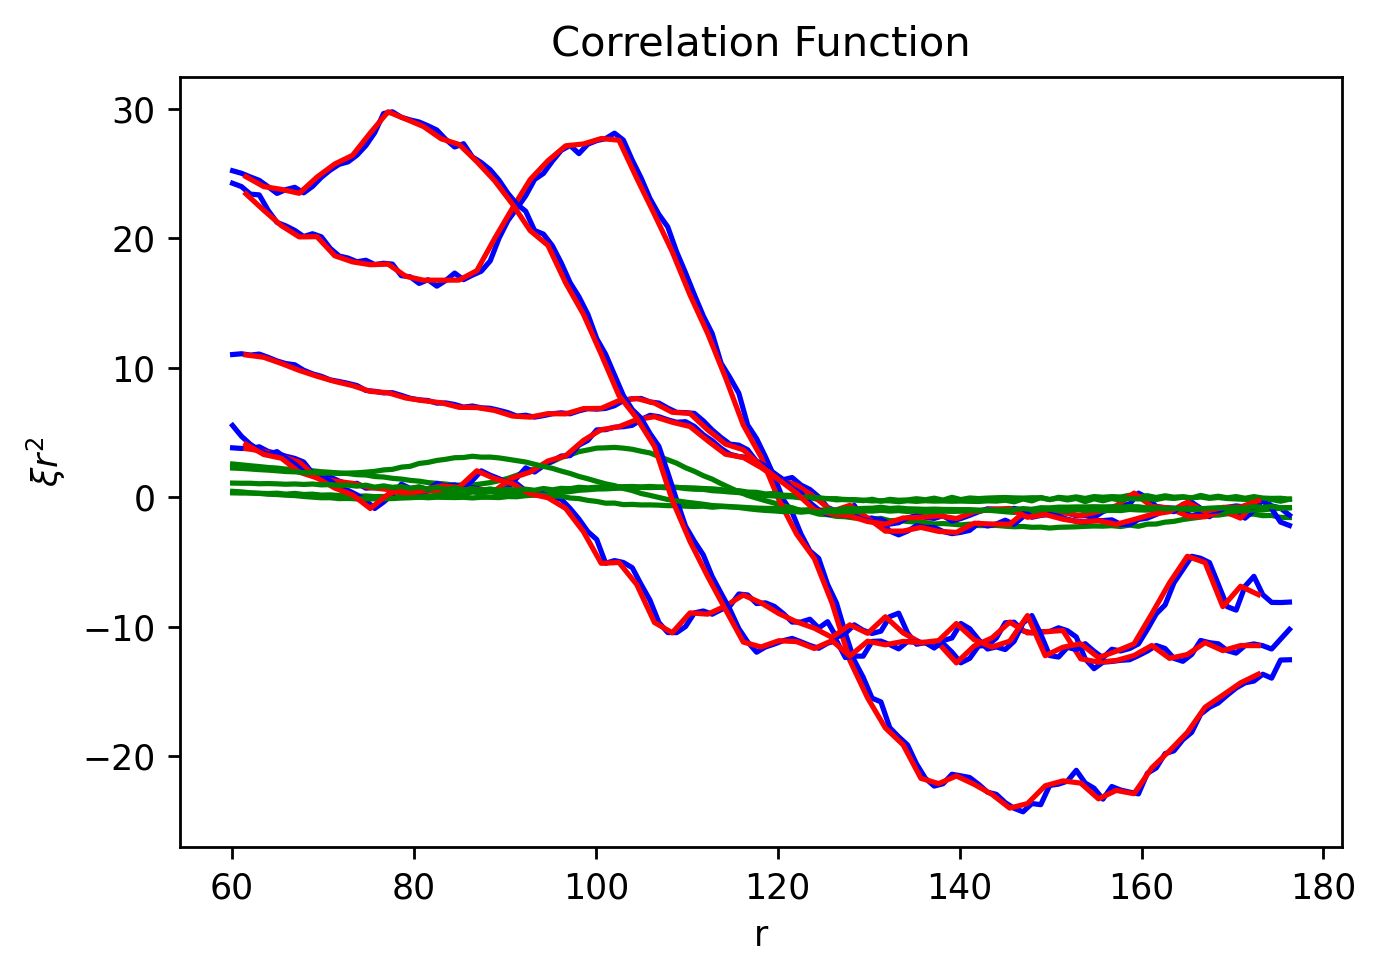

In [42]:
start=60 # start and end indices (not necessarily r)
end=180

binning = 2

fig = plt.figure(figsize=[6,4], dpi=250)
for x in range(1610, 1615): # simulation numbers to plot (0-2000)
    tablexz0 = txt_to_table(x, 0)[start:end] # z = 0
    tablexz3 = txt_to_table(x, 3)[start:end] # z = 3
    
    binnedTable = binCorr(tablexz0, binning)

    
    plt.plot(tablexz0['r'], tablexz0['xi']*tablexz0['r']**2, c='b')
    plt.plot(tablexz3['r'], tablexz3['xi']*tablexz3['r']**2, c='g')
    plt.plot(binnedTable['r'], binnedTable['xi']*binnedTable['r']**2, c='r')

    
    plt.xlabel('r')
    plt.ylabel('$\\xi r^2$')
    plt.title('Correlation Function')

# Neural Network

In [17]:
import torch
from torch import nn, optim

#### Simple 2-layer neural network (no activation function)

In [18]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=kwargs["features"]
        )
        
        
        self.output_layer = nn.Linear(
            in_features=kwargs["features"], out_features=kwargs["output_shape"]
        )

    def forward(self, features):
        encoded = self.input_layer(features)
        reconstructed = self.output_layer(encoded)
        return reconstructed

#### Loading data

In [43]:
from torch.utils.data import TensorDataset, DataLoader

in_start, in_end = 30, 200 # input index range
out_start, out_end = 60, 170 # output index range (narrower than input)

binning = 2

# get data
inputs_t = []
outputs_t = []
for x in range(0, 2000): # all simulations
    tablexz0 = txt_to_table(x, 0)[in_start:in_end]
    tablexz3 = txt_to_table(x, 3)[out_start:out_end]
    
    tablexz0 = binCorr(tablexz0, binning)
    tablexz3 = binCorr(tablexz3, binning)
    
    inputs_t.append(np.array(tablexz0['xi'])*tablexz0['r']**2)
    outputs_t.append(np.array(tablexz3['xi'])*tablexz3['r']**2)

In [44]:
input_shape = len(inputs_t[0]) # input length
output_shape = len(outputs_t[0]) # output length

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
# load it to the specified device, either gpu or cpu
model = AE(input_shape=input_shape, output_shape=output_shape, features=100).to(device)

# mean-squared error loss
criterion = nn.MSELoss()

In [45]:
inputs = np.array(inputs_t)
outputs = np.array(outputs_t)

# divide correlations by mean across all simulations
# i.e. for each r, the correlations are divided by the average correlation for that r
mean_inputs = np.mean(inputs, 0)
mean_outputs = np.mean(outputs, 0)

inputs -= mean_inputs
outputs -= mean_outputs



var_inputs = np.var(inputs, 0)
var_outputs = np.var(outputs, 0)

inputs /= var_inputs
outputs /= var_outputs

In [46]:
# which simulations to train on (rest are for testing)
train_sample_min, train_sample_max = 0, 1000


tensor_train_x = torch.Tensor(inputs[train_sample_min:train_sample_max]) # transform to torch tensor
tensor_train_y = torch.Tensor(outputs[train_sample_min:train_sample_max])

tensor_test_x = torch.Tensor(inputs[train_sample_max:2000]) # transform to torch tensor
tensor_test_y = torch.Tensor(outputs[train_sample_max:2000])


train_dataset = TensorDataset(tensor_train_x,tensor_train_y) # create datset
train_dataloader = DataLoader(train_dataset, shuffle=True) # create dataloader

test_dataset = TensorDataset(tensor_test_x, tensor_test_y) # create datset
test_dataloader = DataLoader(test_dataset, shuffle=True) # create dataloader

In [48]:
# create an optimizer object
# Adam optimizer with learning rate + decay
optimizer = optim.Adam(model.parameters(), lr=1e-5)
decayRate = 0.999
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# Run model

In [49]:
epochs = 1000
#train_losses = []
#test_losses = []

for epoch in range(epochs):
    train_loss_tot, test_loss_tot = 0, 0
    
    #################
    # Training Loop #
    #################
    model.train(True) 
    for batch_features, batch_labels in train_dataloader:
        # reset the gradients back to zero
        optimizer.zero_grad()
        
        # compute reconstructions
        model_outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(model_outputs, batch_labels)
        # train_loss = loss_criterion(outputs, batch_labels)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        train_loss_tot += train_loss.item()
    
    
    ################
    # Testing Loop #
    ################
    model.train(False)
    for batch_features, batch_labels in test_dataloader:
        # compute reconstructions
        model_outputs = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(model_outputs, batch_labels)
        # test_loss = loss_criterion(outputs, batch_labels)
        
        # add the mini-batch training loss to epoch loss
        test_loss_tot += test_loss.item()
    
    # compute the epoch training loss
    train_loss_tot = train_loss_tot# / len(train_dataloader)
    test_loss_tot = test_loss_tot# / len(test_dataloader)
    
    # record losses
    train_losses.append(train_loss_tot)
    test_losses.append(test_loss_tot)
    
    # learning rate decay step
    lr_scheduler.step()
    
    # display the epoch losses
    print("epoch : {}/{}, train loss = {:.10f}, test loss = {:.10f}".format(epoch + 1, epochs, train_loss_tot, test_loss_tot))

epoch : 1/1000, train loss = 8.2704091140, test loss = 6.0364978989
epoch : 2/1000, train loss = 6.1401014432, test loss = 4.7730093008
epoch : 3/1000, train loss = 5.2143161204, test loss = 4.1474029496
epoch : 4/1000, train loss = 4.6546228371, test loss = 3.7102032015
epoch : 5/1000, train loss = 4.2137096598, test loss = 3.3604750648
epoch : 6/1000, train loss = 3.7627647994, test loss = 2.9383853741
epoch : 7/1000, train loss = 3.2907823317, test loss = 2.5445303530
epoch : 8/1000, train loss = 2.8084321402, test loss = 2.1274847023
epoch : 9/1000, train loss = 2.3604963160, test loss = 1.7586837544
epoch : 10/1000, train loss = 1.9250155103, test loss = 1.4107730602
epoch : 11/1000, train loss = 1.5233616633, test loss = 1.0787706782
epoch : 12/1000, train loss = 1.1888845269, test loss = 0.8358429820
epoch : 13/1000, train loss = 0.9268297343, test loss = 0.6333828113
epoch : 14/1000, train loss = 0.7194734534, test loss = 0.4895961091
epoch : 15/1000, train loss = 0.5708272495,

epoch : 120/1000, train loss = 0.1247731488, test loss = 0.0821223103
epoch : 121/1000, train loss = 0.1242318529, test loss = 0.0817038402
epoch : 122/1000, train loss = 0.1241816967, test loss = 0.0814364143
epoch : 123/1000, train loss = 0.1236412434, test loss = 0.0814735058
epoch : 124/1000, train loss = 0.1231633242, test loss = 0.0817269267
epoch : 125/1000, train loss = 0.1226952606, test loss = 0.0809230244
epoch : 126/1000, train loss = 0.1225201053, test loss = 0.0807218455
epoch : 127/1000, train loss = 0.1215042722, test loss = 0.0799468909
epoch : 128/1000, train loss = 0.1214273196, test loss = 0.0799973085
epoch : 129/1000, train loss = 0.1207482646, test loss = 0.0796837654
epoch : 130/1000, train loss = 0.1202214220, test loss = 0.0799326893
epoch : 131/1000, train loss = 0.1204534998, test loss = 0.0792433566
epoch : 132/1000, train loss = 0.1194057171, test loss = 0.0793401267
epoch : 133/1000, train loss = 0.1195572215, test loss = 0.0792971286
epoch : 134/1000, tr

epoch : 238/1000, train loss = 0.0893010823, test loss = 0.0622823586
epoch : 239/1000, train loss = 0.0891019871, test loss = 0.0621888093
epoch : 240/1000, train loss = 0.0886291549, test loss = 0.0621357732
epoch : 241/1000, train loss = 0.0887320333, test loss = 0.0619891718
epoch : 242/1000, train loss = 0.0882475201, test loss = 0.0620315102
epoch : 243/1000, train loss = 0.0879802677, test loss = 0.0618446348
epoch : 244/1000, train loss = 0.0878919417, test loss = 0.0617540285
epoch : 245/1000, train loss = 0.0876920871, test loss = 0.0617038912
epoch : 246/1000, train loss = 0.0872190721, test loss = 0.0615112516
epoch : 247/1000, train loss = 0.0871860822, test loss = 0.0611582548
epoch : 248/1000, train loss = 0.0872027626, test loss = 0.0610420359
epoch : 249/1000, train loss = 0.0871092288, test loss = 0.0609223321
epoch : 250/1000, train loss = 0.0861965603, test loss = 0.0608347866
epoch : 251/1000, train loss = 0.0866699063, test loss = 0.0607098391
epoch : 252/1000, tr

epoch : 356/1000, train loss = 0.0667982429, test loss = 0.0486677804
epoch : 357/1000, train loss = 0.0668248456, test loss = 0.0485038366
epoch : 358/1000, train loss = 0.0670139803, test loss = 0.0486552693
epoch : 359/1000, train loss = 0.0668073294, test loss = 0.0484859039
epoch : 360/1000, train loss = 0.0665840920, test loss = 0.0486625389
epoch : 361/1000, train loss = 0.0663898713, test loss = 0.0484225076
epoch : 362/1000, train loss = 0.0659478298, test loss = 0.0483787057
epoch : 363/1000, train loss = 0.0660312157, test loss = 0.0480858526
epoch : 364/1000, train loss = 0.0660631743, test loss = 0.0484363603
epoch : 365/1000, train loss = 0.0657685100, test loss = 0.0480393690
epoch : 366/1000, train loss = 0.0654703660, test loss = 0.0476728360
epoch : 367/1000, train loss = 0.0656163983, test loss = 0.0476930193
epoch : 368/1000, train loss = 0.0652506101, test loss = 0.0475633759
epoch : 369/1000, train loss = 0.0653882147, test loss = 0.0476103633
epoch : 370/1000, tr

epoch : 474/1000, train loss = 0.0526426268, test loss = 0.0392073737
epoch : 475/1000, train loss = 0.0526731977, test loss = 0.0392284106
epoch : 476/1000, train loss = 0.0524384869, test loss = 0.0392255384
epoch : 477/1000, train loss = 0.0524489861, test loss = 0.0392640024
epoch : 478/1000, train loss = 0.0521249139, test loss = 0.0388078156
epoch : 479/1000, train loss = 0.0526407991, test loss = 0.0388175161
epoch : 480/1000, train loss = 0.0521177668, test loss = 0.0386213270
epoch : 481/1000, train loss = 0.0519121273, test loss = 0.0386661852
epoch : 482/1000, train loss = 0.0521708838, test loss = 0.0386622278
epoch : 483/1000, train loss = 0.0519948239, test loss = 0.0385089083
epoch : 484/1000, train loss = 0.0518431008, test loss = 0.0385161450
epoch : 485/1000, train loss = 0.0516413696, test loss = 0.0385750641
epoch : 486/1000, train loss = 0.0517385605, test loss = 0.0386096306
epoch : 487/1000, train loss = 0.0514301047, test loss = 0.0388638278
epoch : 488/1000, tr

epoch : 592/1000, train loss = 0.0458086738, test loss = 0.0344844941
epoch : 593/1000, train loss = 0.0455168540, test loss = 0.0345932316
epoch : 594/1000, train loss = 0.0452983048, test loss = 0.0350653716
epoch : 595/1000, train loss = 0.0454186124, test loss = 0.0349547034
epoch : 596/1000, train loss = 0.0456273854, test loss = 0.0346550128
epoch : 597/1000, train loss = 0.0455061611, test loss = 0.0345035982
epoch : 598/1000, train loss = 0.0454498697, test loss = 0.0344842014
epoch : 599/1000, train loss = 0.0454398803, test loss = 0.0343133647
epoch : 600/1000, train loss = 0.0454696837, test loss = 0.0342661050
epoch : 601/1000, train loss = 0.0454557045, test loss = 0.0345359228
epoch : 602/1000, train loss = 0.0453620511, test loss = 0.0341822419
epoch : 603/1000, train loss = 0.0452800605, test loss = 0.0346137269
epoch : 604/1000, train loss = 0.0452401150, test loss = 0.0342238346
epoch : 605/1000, train loss = 0.0451261757, test loss = 0.0339991409
epoch : 606/1000, tr

epoch : 710/1000, train loss = 0.0427962023, test loss = 0.0325246953
epoch : 711/1000, train loss = 0.0423361661, test loss = 0.0323701017
epoch : 712/1000, train loss = 0.0425322215, test loss = 0.0323576266
epoch : 713/1000, train loss = 0.0427283373, test loss = 0.0323426879
epoch : 714/1000, train loss = 0.0425908671, test loss = 0.0323621402
epoch : 715/1000, train loss = 0.0423892777, test loss = 0.0323360581
epoch : 716/1000, train loss = 0.0427176783, test loss = 0.0323890170
epoch : 717/1000, train loss = 0.0424837066, test loss = 0.0326626778
epoch : 718/1000, train loss = 0.0425921171, test loss = 0.0326817953
epoch : 719/1000, train loss = 0.0424789637, test loss = 0.0323341109
epoch : 720/1000, train loss = 0.0423042188, test loss = 0.0325518789
epoch : 721/1000, train loss = 0.0421209738, test loss = 0.0323527161
epoch : 722/1000, train loss = 0.0423095125, test loss = 0.0323392956
epoch : 723/1000, train loss = 0.0425003100, test loss = 0.0322739811
epoch : 724/1000, tr

epoch : 828/1000, train loss = 0.0410107090, test loss = 0.0318349372
epoch : 829/1000, train loss = 0.0411774778, test loss = 0.0317486214
epoch : 830/1000, train loss = 0.0410253655, test loss = 0.0316848805
epoch : 831/1000, train loss = 0.0407741964, test loss = 0.0315685174
epoch : 832/1000, train loss = 0.0409886846, test loss = 0.0314988820
epoch : 833/1000, train loss = 0.0409437231, test loss = 0.0315248904
epoch : 834/1000, train loss = 0.0409953496, test loss = 0.0316098201
epoch : 835/1000, train loss = 0.0409391261, test loss = 0.0315418504
epoch : 836/1000, train loss = 0.0409992399, test loss = 0.0316422612
epoch : 837/1000, train loss = 0.0408077310, test loss = 0.0314664905
epoch : 838/1000, train loss = 0.0408375793, test loss = 0.0316064984
epoch : 839/1000, train loss = 0.0408086497, test loss = 0.0314569974
epoch : 840/1000, train loss = 0.0409239887, test loss = 0.0315651208
epoch : 841/1000, train loss = 0.0408793657, test loss = 0.0315051502
epoch : 842/1000, tr

epoch : 946/1000, train loss = 0.0399594469, test loss = 0.0308950409
epoch : 947/1000, train loss = 0.0400546781, test loss = 0.0310148107
epoch : 948/1000, train loss = 0.0400410345, test loss = 0.0311157472
epoch : 949/1000, train loss = 0.0400165681, test loss = 0.0310749984
epoch : 950/1000, train loss = 0.0398502380, test loss = 0.0311287115
epoch : 951/1000, train loss = 0.0400424044, test loss = 0.0311604970
epoch : 952/1000, train loss = 0.0399141959, test loss = 0.0310247555
epoch : 953/1000, train loss = 0.0398577634, test loss = 0.0309734199
epoch : 954/1000, train loss = 0.0399927350, test loss = 0.0309316733
epoch : 955/1000, train loss = 0.0397121825, test loss = 0.0308129292
epoch : 956/1000, train loss = 0.0399980844, test loss = 0.0309204422
epoch : 957/1000, train loss = 0.0398314483, test loss = 0.0309125456
epoch : 958/1000, train loss = 0.0398458632, test loss = 0.0310137245
epoch : 959/1000, train loss = 0.0398867660, test loss = 0.0310460557
epoch : 960/1000, tr

# Plot Outputs

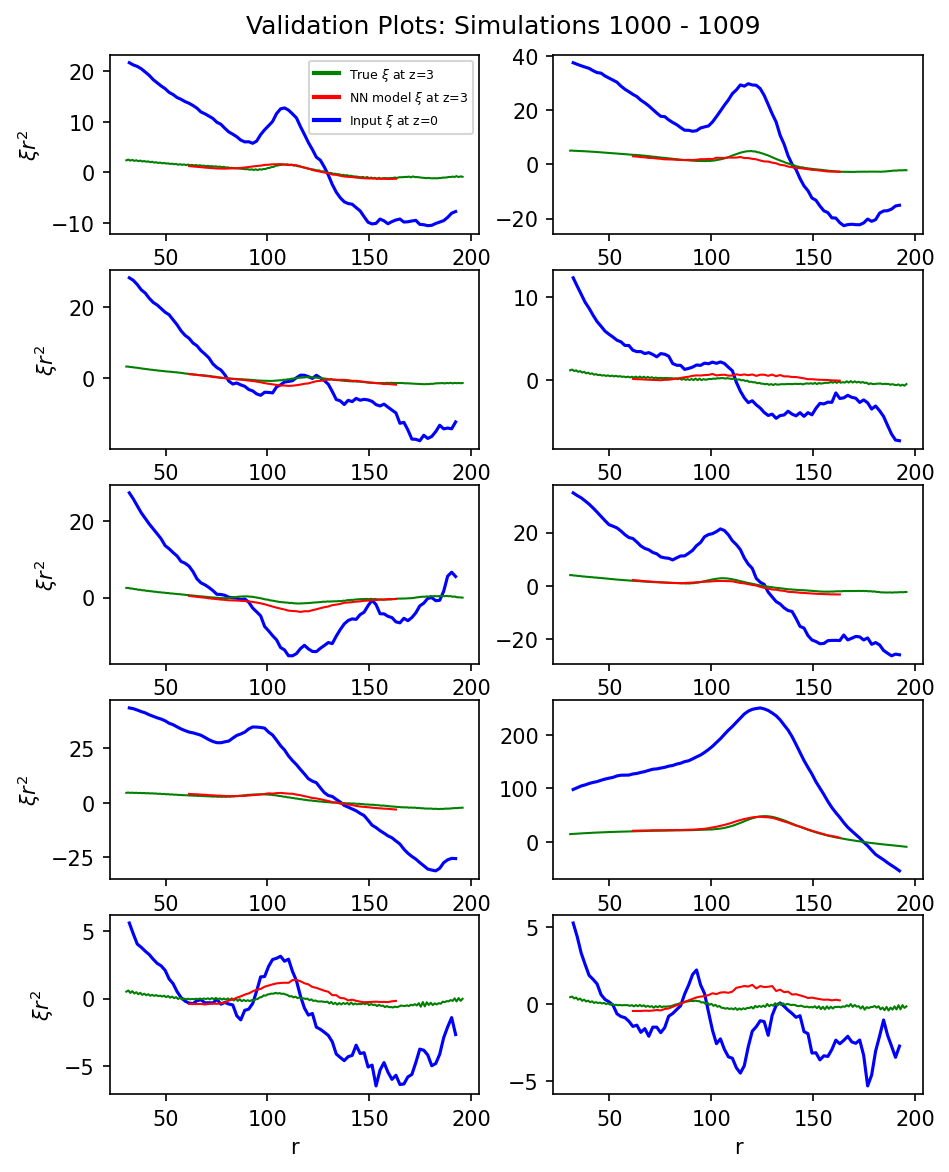

In [51]:
start_plot = 1000
end_plot = 1010

num_row = int((end_plot-start_plot)/2)
fig, ax = plt.subplots(num_row, 2, figsize=[7,9], dpi=150)

for x in range(start_plot, end_plot):
    tablexz0 = txt_to_table(x, 0)[in_start:in_end]
    tablexz3 = txt_to_table(x, 3)[out_start:out_end]
    
    tablexz0 = binCorr(tablexz0, binning)
    tablexz3 = binCorr(tablexz3, binning)
    
    
    tablexz3_long = txt_to_table(x, 3)[in_start:in_end]
    true_xi = tablexz3_long['xi']*tablexz3_long['r']**2
    model_xi = model(torch.Tensor((tablexz0['xi']*tablexz0['r']**2-mean_inputs)/var_inputs)).detach().numpy()*var_outputs+mean_outputs
    #print(np.mean((np.array(true_xi)-np.array(model_load_xi))**2
    
    ax_num = x - start_plot
    row = int(np.floor(ax_num/2))
    col = int((ax_num/2. - row)*2)
    ax[row, col].plot(tablexz0['r'], tablexz0['xi']*tablexz0['r']**2, c='b')
    ax[row, col].plot(tablexz3_long['r'], true_xi, c='g', lw=1)
    ax[row, col].plot(tablexz3['r'], model_xi, c='r', lw=1)
    
    
custom_lines = [Line2D([0], [0], color='g', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]

if start_plot >= 1000:
    if end_plot - start_plot > 1:
        fig.suptitle(f'Validation Plots: Simulations {start_plot} - {end_plot - 1}', y=0.91)
    else:
        fig.suptitle(f'Validation Plot: Simulation {start_plot}', y=0.91)

else:
    if end_plot - start_plot > 1:
        fig.suptitle(f'Training Plots: Simulations {start_plot} - {end_plot - 1}', y=0.91)
    else:
        fig.suptitle(f'Training Plot: Simulation {start_plot}', y=0.91)

        

ax[-1, 0].set_xlabel('r')
ax[-1, 1].set_xlabel('r')

for i in range(num_row):
    ax[i, 0].set_ylabel('$\\xi r^2$')

ax[0,0].legend(custom_lines, ['True $\\xi$ at z=3', 'NN model $\\xi$ at z=3', 'Input $\\xi$ at z=0'], fontsize=6)

In [53]:
start_plot = 1000
end_plot = 2000


validation_output = np.zeros([1000, 53])
true_output = np.zeros([1000, 53])

for x in range(start_plot, end_plot):
    print(x)
    tablexz0 = txt_to_table(x, 0)[in_start:in_end]
    tablexz3 = txt_to_table(x, 3)[out_start:out_end]
    
    
    tablexz0 = binCorr(tablexz0, binning)
    tablexz3 = binCorr(tablexz3, binning)
    
    
    tablexz3_long = txt_to_table(x, 3)[in_start:in_end]
    true_xi = tablexz3['xi']*tablexz3['r']**2
    model_xi = model(torch.Tensor((tablexz0['xi']*tablexz0['r']**2-mean_inputs)/var_inputs)).detach().numpy()*var_outputs+mean_outputs
    validation_output[x-start_plot] = model_xi
    true_output[x-start_plot] = true_xi
    


1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


In [54]:
validation_average = np.mean(validation_output, 0)
true_average = np.mean(true_output, 0)

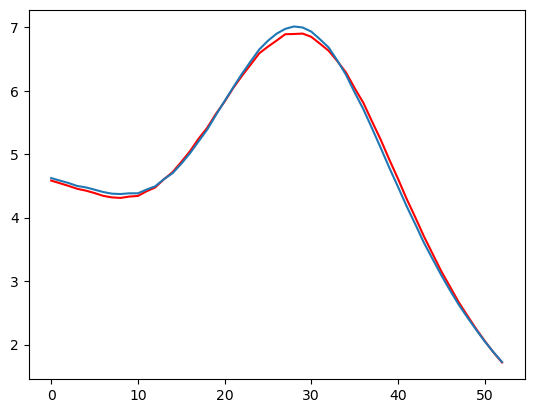

In [55]:
plt.plot(validation_average, c='red')
plt.plot(true_average)

In [84]:
# save model
torch.save(model.state_dict(), 'trained_weights.pth')

In [16]:
# load saved model
model_load = AE(input_shape=input_shape, output_shape=output_shape, features=200).to(device)
model_load.load_state_dict(torch.load('trained_weights_1000.pth'))
model_load.eval()

AE(
  (input_layer): Linear(in_features=120, out_features=200, bias=True)
  (output_layer): Linear(in_features=200, out_features=100, bias=True)
)

'trained_weights_1000.pth' was trained on:
in_start, in_end = 60, 180 
out_start, out_end = 70, 170

features = 200